## Script to capture components in sales for demand generation

### Import

In [57]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import preprocessing

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

from scipy import stats

### Trend

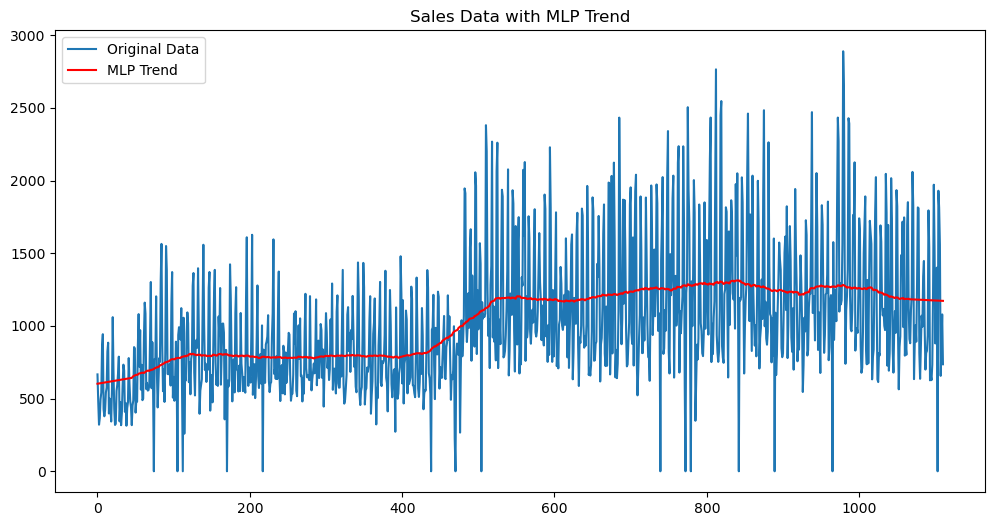

<Figure size 1200x600 with 0 Axes>

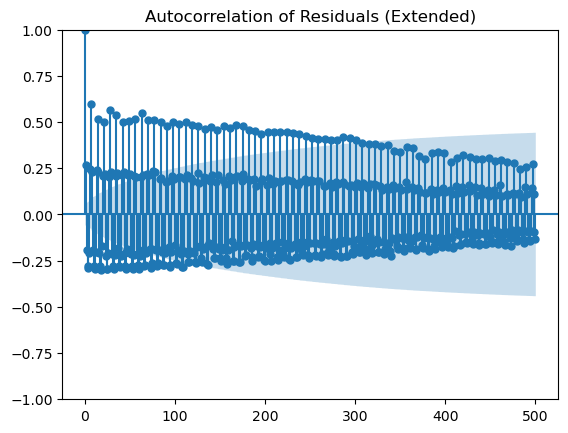

Mean of residuals: -2.657787136974823
Standard deviation of residuals: 407.82084644125547


In [58]:
# Function to generate trend for any time t
def T(t):
    t_scaled = scaler_X.transform([[t]])
    return scaler_y.inverse_transform(mlp.predict(t_scaled).reshape(-1, 1))[0][0]


# Read the data
df = pd.read_csv('RestaurantDataVets_All_2to5.csv')
sales = df['2to5'].values
time = np.arange(len(sales)).reshape(-1, 1)

# Normalize the input
scaler_X = StandardScaler()
scaler_y = StandardScaler()
time_scaled = scaler_X.fit_transform(time)
sales_scaled = scaler_y.fit_transform(sales.reshape(-1, 1)).ravel()

# Fit MLP
mlp = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42)
mlp.fit(time_scaled, sales_scaled)

# Extract trend
trend_scaled = mlp.predict(time_scaled)
trend = scaler_y.inverse_transform(trend_scaled.reshape(-1, 1)).ravel()

# Extract MLP trend
mlp_trend_scaled = mlp.predict(time_scaled)
mlp_trend = scaler_y.inverse_transform(mlp_trend_scaled.reshape(-1, 1)).ravel()

# Calculate long-term moving average
window = 90  # Adjust this value based on your data
ma_trend = pd.Series(sales).rolling(window=window, center=True).mean()

# Combine MLP and MA trends
trend = (mlp_trend + ma_trend.bfill().ffill()) / 2

# Calculate residuals
residuals = sales - trend

# Plot original data and trend
plt.figure(figsize=(12, 6))
plt.plot(time, sales, label='Original Data')
plt.plot(time, trend, label='MLP Trend', color='red')
plt.legend()
plt.title('Sales Data with MLP Trend')
plt.show()

# Plot ACF of residuals with expanded lag
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=500)  # Increased lags to see long-term behavior
plt.title('Autocorrelation of Residuals (Extended)')
plt.show()

# Print some statistics
print(f"Mean of residuals: {np.mean(residuals)}")
print(f"Standard deviation of residuals: {np.std(residuals)}")

### Weekly Seasonality

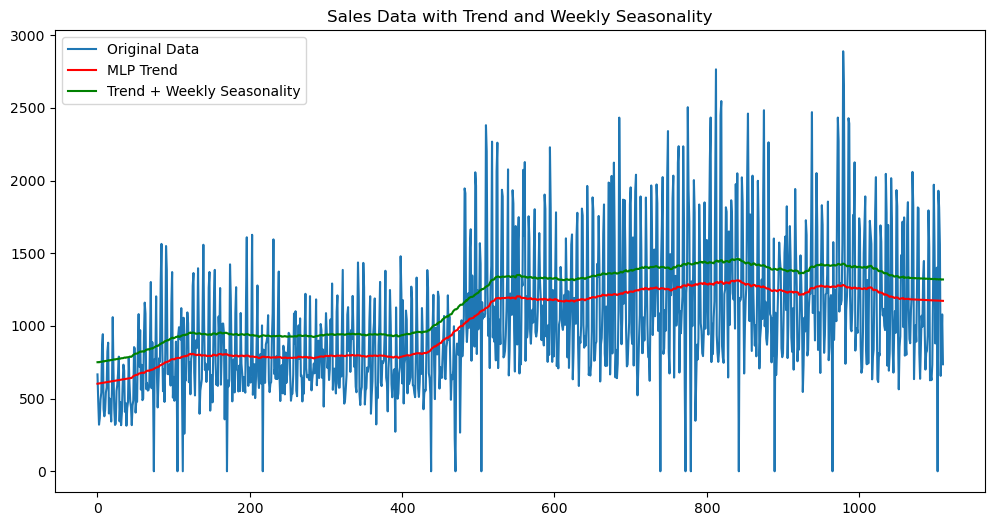

<Figure size 1200x600 with 0 Axes>

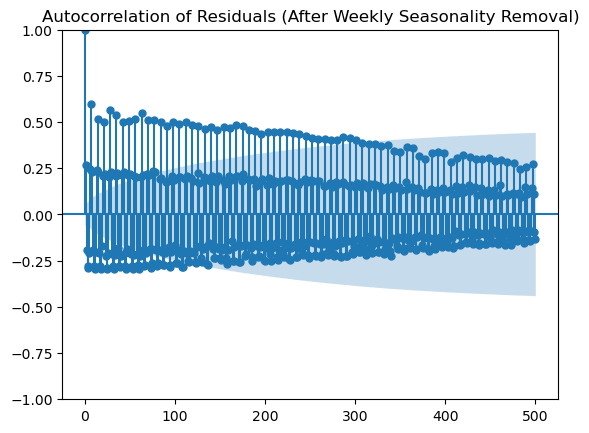

Mean Absolute Error: 364.30794015242924
Root Mean Squared Error: 434.26791415690974
RMSE as percentage of mean sales: 42.24710249093627%
R-squared: 0.15336585626146948


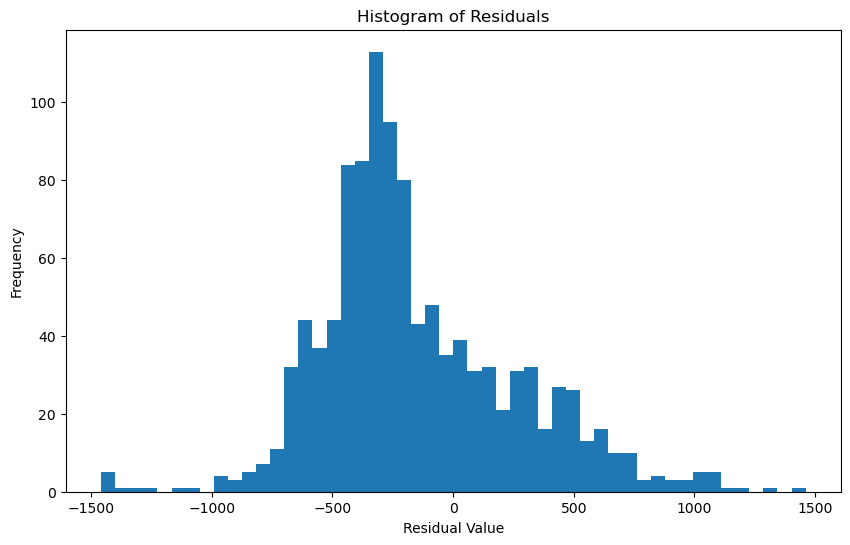

In [59]:
# Extract weekly seasonality from one-hot encoded columns
day_columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekly_seasonality = df[day_columns].mean().values * df['2to5'].mean()

# Function to get weekly seasonality for any time t
def W(t):
    return weekly_seasonality[t % 7]

# Apply weekly seasonality to the entire dataset
weekly_component = np.array([W(t) for t in range(len(sales))])

# Calculate new residuals
new_residuals = residuals - weekly_component

# Plot original data, trend, and trend + weekly seasonality
plt.figure(figsize=(12, 6))
plt.plot(time, sales, label='Original Data')
plt.plot(time, trend, label='MLP Trend', color='red')
plt.plot(time, trend + weekly_component, label='Trend + Weekly Seasonality', color='green')
plt.legend()
plt.title('Sales Data with Trend and Weekly Seasonality')
plt.show()

# Plot ACF of new residuals
plt.figure(figsize=(12, 6))
plot_acf(new_residuals, lags=500)
plt.title('Autocorrelation of Residuals (After Weekly Seasonality Removal)')
plt.show()

# Calculate and print accuracy metrics
# RMSE aim for 15%~30%, R_square aims for 0.6~0.8, 
y_pred = trend + weekly_component
mae = mean_absolute_error(sales, y_pred)
rmse = np.sqrt(mean_squared_error(sales, y_pred))
r2 = r2_score(sales, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"RMSE as percentage of mean sales: {rmse / np.mean(sales) * 100}%")
print(f"R-squared: {r2}")

# Plot histogram of residuals
# should follow similar normal distribution
plt.figure(figsize=(10, 6))
plt.hist(new_residuals, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()


### Holiday

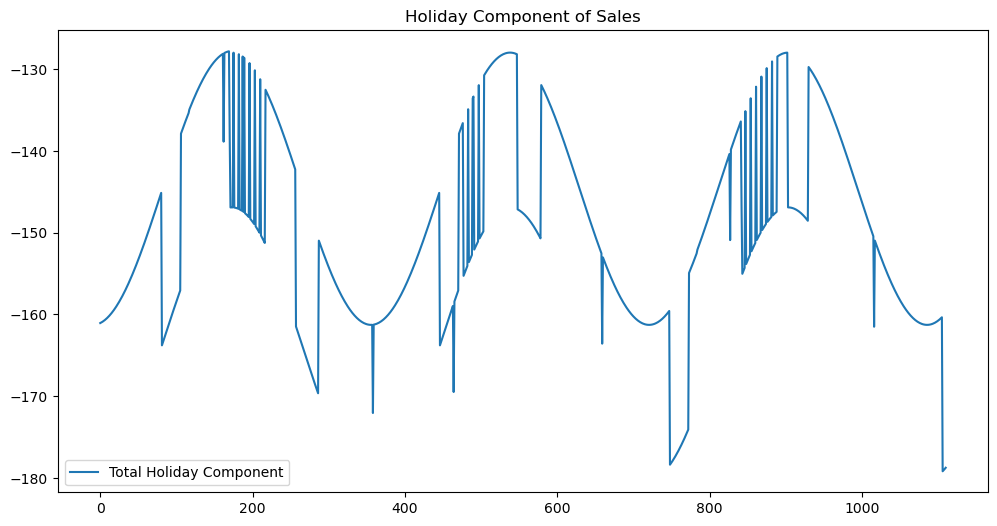

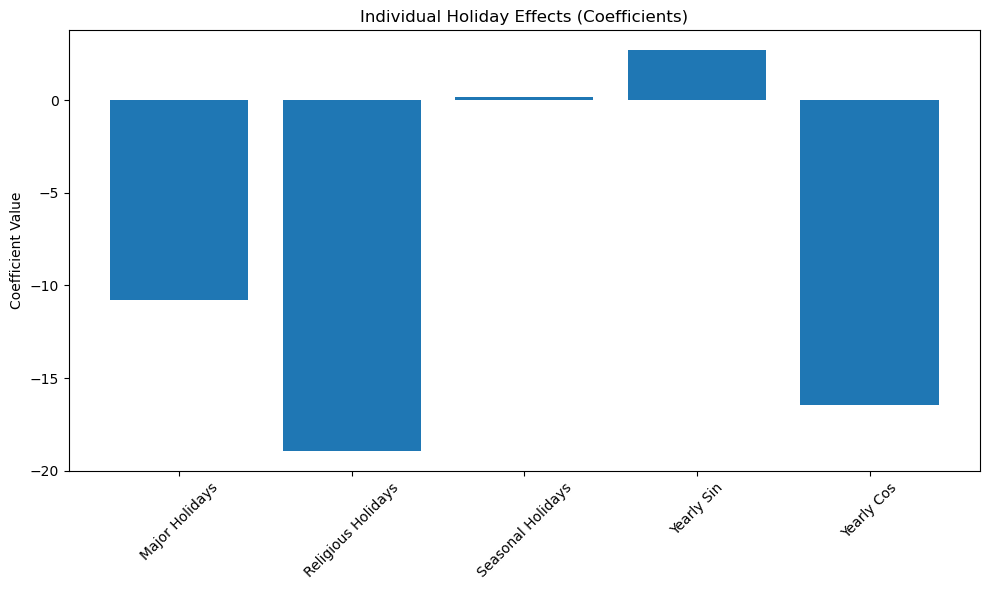

<Figure size 1200x600 with 0 Axes>

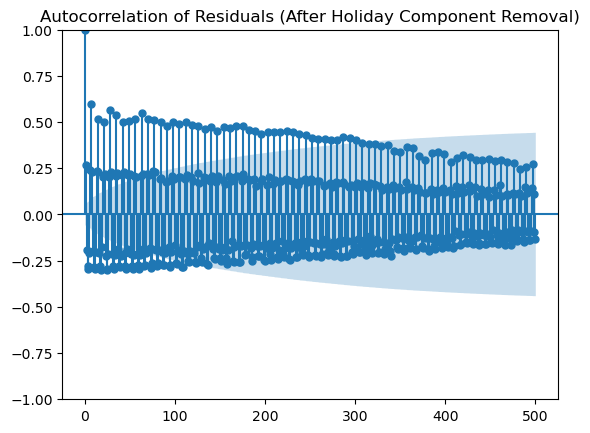

Mean Absolute Error: 317.23622255105295
Root Mean Squared Error: 407.2465455664484
RMSE as percentage of mean sales: 39.61836918812516%
R-squared: 0.2554478675013848


In [60]:
#Takes a dataframe with the holiday field and returns encoded dataframe.
def onehotholiday(select):
    X_2 = select[['Holiday']]
    # Create a OneHotEncoder object
    enc = preprocessing.OneHotEncoder(sparse=False)
    
    # Fit and transform
    onehotlabels = enc.fit_transform(X_2)
    
    # Create column names
    column_values = [f'Holiday_{i}' for i in range(onehotlabels.shape[1])]

    # Create the dataframe 
    onehotholiday = pd.DataFrame(data=onehotlabels, columns=column_values)

    # Join with original dataset
    dataset = select.drop(columns=['Holiday'])
    dataset = dataset.join(onehotholiday)
    
    # Reorder columns to put '2to5' at the end
    cols = [col for col in dataset.columns if col != '2to5'] + ['2to5']
    dataset = dataset[cols]
    
    return dataset

def group_holidays(df):
    # Group similar holidays -- use real life experiences and impact plot 
    # to reduce the risk of overfitting
    major_holidays = ['Holiday_3', 'Holiday_6', 'Holiday_18']  # those who have consistently large impact on sales
    religious_holidays = ['Ramadan', 'ChristmasSeason', 'LentFasting'] # the Christmas has significant impact while others have subtle
    seasonal_holidays = ['Carnival'] # consistent positive impact
    
    df['major_holidays'] = df[major_holidays].max(axis=1)
    df['religious_holidays'] = df[religious_holidays].max(axis=1)
    df['seasonal_holidays'] = df[seasonal_holidays]
    
    return df[['major_holidays', 'religious_holidays', 'seasonal_holidays']]

def extract_holiday_components(df, trend, weekly_component, sales_column='2to5'):
    # Group holidays
    holiday_features = group_holidays(df)
    
    # Calculate residuals after removing trend and weekly seasonality
    residuals = df[sales_column] - trend - weekly_component

    # Prepare features for Ridge regression
    X = np.column_stack([holiday_features, 
                         np.sin(2 * np.pi * np.arange(len(df)) / 365),  # Yearly seasonality
                         np.cos(2 * np.pi * np.arange(len(df)) / 365)])

    # Use Ridge regression with cross-validation for regularization
    alphas = np.logspace(-3, 3, 50)
    ridge = Ridge()
    scores = [cross_val_score(Ridge(alpha=alpha), X, residuals, cv=5).mean()
              for alpha in alphas]
    best_alpha = alphas[np.argmax(scores)]
    
    # Fit the model with the best alpha
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X, residuals)
    
    # Extract holiday components
    holiday_component = ridge.predict(X)

    # Function to get holiday component for any time t
    def H(t):
        t = t % len(holiday_component)
        return holiday_component[t]

    return H, holiday_component, ridge.coef_

df = onehotholiday(df)
H, holiday_component, holiday_coefficients = extract_holiday_components(df, trend, weekly_component)

# Visualization and analysis code
# Plot to visualize the total holiday component
plt.figure(figsize=(12, 6))
plt.plot(df.index, holiday_component, label='Total Holiday Component')
plt.title('Holiday Component of Sales')
plt.legend()
plt.show()

# Plot individual holiday effects (coefficients)
plt.figure(figsize=(10, 6))
effect_names = ['Major Holidays', 'Religious Holidays', 'Seasonal Holidays', 'Yearly Sin', 'Yearly Cos']
plt.bar(effect_names, holiday_coefficients)
plt.title('Individual Holiday Effects (Coefficients)')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate new residuals after removing holiday component
new_residuals = residuals - holiday_component

# Plot ACF of new residuals
plt.figure(figsize=(12, 6))
plot_acf(new_residuals, lags=500)
plt.title('Autocorrelation of Residuals (After Holiday Component Removal)')
plt.show()

# Update the combined model
y_pred_with_holidays = trend + weekly_component + holiday_component

# Recalculate and print accuracy metrics
mae = mean_absolute_error(df['2to5'], y_pred_with_holidays)
rmse = np.sqrt(mean_squared_error(df['2to5'], y_pred_with_holidays))
r2 = r2_score(df['2to5'], y_pred_with_holidays)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"RMSE as percentage of mean sales: {rmse / np.mean(df['2to5']) * 100}%")
print(f"R-squared: {r2}")

#  the impact of holidays has some patterns, which means annual holiday seasons
# for decrease in performance, it might due to Multicollinearity, overfitting of noises, assumption of additive effects might not hold

### Noise term and verification of suitability

Original Mean: 1027.92
Simulation Mean (avg): 1027.98
Original Std: 472.18
Simulation Std (avg): 467.96


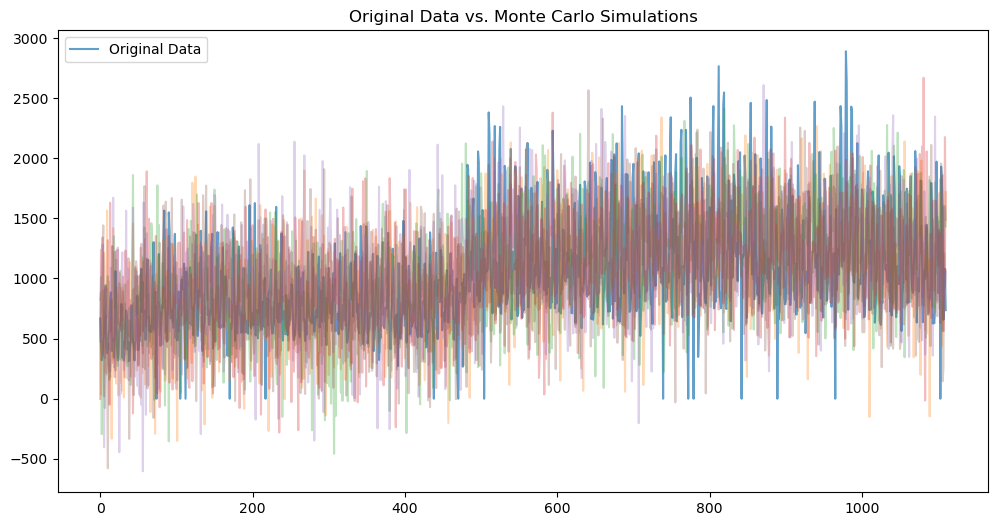

In [61]:
def add_noise_term(y_pred, residuals): # to preserve variability 
    # Fit a normal distribution to the residuals
    mu, std = stats.norm.fit(residuals)
    
    # Generate noise terms (normal)
    noise = np.random.normal(mu, std, len(y_pred))
    
    # Add noise to predictions
    y_sim = y_pred + noise
    
    return y_sim

# Run the simulation to compare with original data to verify the alignment of:
# Statistical properties
# Temporal patterns
# Autocorrelation
# Extreme values
def monte_carlo_simulation(df, trend, weekly_component, holiday_component, n_simulations=1000):
    # Combine deterministic components
    y_pred = trend + weekly_component + holiday_component
    
    # Calculate residuals
    residuals = df['2to5'] - y_pred
    
    # Generate simulations
    simulations = np.zeros((len(df), n_simulations))
    for i in range(n_simulations):
        simulations[:, i] = add_noise_term(y_pred, residuals)
    
    return simulations

# Generate simulations
simulations = monte_carlo_simulation(df, trend, weekly_component, holiday_component)

# Verify statistical properties
original_mean = df['2to5'].mean()
original_std = df['2to5'].std()
sim_means = simulations.mean(axis=0)
sim_stds = simulations.std(axis=0)

print(f"Original Mean: {original_mean:.2f}")
print(f"Simulation Mean (avg): {sim_means.mean():.2f}")
print(f"Original Std: {original_std:.2f}")
print(f"Simulation Std (avg): {sim_stds.mean():.2f}")

# Plot original data and some simulations
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['2to5'], label='Original Data', alpha=0.7)
for i in range(5):  # Plot 5 random simulations
    plt.plot(df.index, simulations[:, i], alpha=0.3)
plt.title('Original Data vs. Monte Carlo Simulations')
plt.legend()
plt.show()

# the mean and std are both close enough, which indicates the simulation is quite good
# while the std of original data is large enough, the variation -- randomness of Monto Carlo Simulation can be ensured

### Demand Generation

In [69]:
# since the function of components are all too complicated to be explicitly expressed as formulas,
# arrays are generated representing unit time demands
# random demand for simulations are then using imported file
# this might also benefit the reproductivity

from tqdm import tqdm

def generate_future_demand_array(start_day, sim_days, n_scenarios):
    n_original_days = 1091  # Original dataset length
    demands = np.zeros((sim_days, n_scenarios))

    for scenario in tqdm(range(n_scenarios)):
        for t in range(sim_days):
            actual_day = start_day + t
            pattern_day = actual_day % n_original_days

            day_trend = T(actual_day)
            day_weekly = W(pattern_day)
            day_holiday = H(pattern_day)

            base_demand = day_trend + day_weekly + day_holiday
            demands[t, scenario] = add_noise_term(np.array([base_demand]), np.array([new_residuals[pattern_day]]))[0]

    # Apply scaling factor
    # scaled_demands = demands / scale_factor
    # scaled_demands = (demands - sim_means) / sim_stds
    return demands

In [70]:
# Specify simulation parameters
start_day = 1091  # Start immediately after the original dataset
sim_days = 5000  # For example, generate one year of future demand
n_scenarios = 100  # Number of scenarios to generate

In [71]:
print(f"Generating scaled future demand array for {sim_days} simulation days starting from day {start_day}, with {n_scenarios} scenarios...")
# print(f"All demands will be divided by {scale_factor}")

demand_array = generate_future_demand_array(start_day, sim_days, n_scenarios)

# Save the scaled future demand array to a file
output_file = 'simulation_demand.npy'
print(f"Saving scaled future demand array to {output_file}...")
np.save(output_file, demand_array)
print("Scaled future demand array saved successfully.")

simulation_demand = np.load('simulation_demand.npy')
simulation_demand

Generating scaled future demand array for 5000 simulation days starting from day 1091, with 100 scenarios...
Saving scaled future demand array to simulation_demand.npy...
Scaled future demand array saved successfully.


array([[1394.05241675, 1394.05241675, 1394.05241675, ..., 1394.05241675,
        1394.05241675, 1394.05241675],
       [1201.69880545, 1201.69880545, 1201.69880545, ..., 1201.69880545,
        1201.69880545, 1201.69880545],
       [1042.579523  , 1042.579523  , 1042.579523  , ..., 1042.579523  ,
        1042.579523  , 1042.579523  ],
       ...,
       [ 769.63571485,  769.63571485,  769.63571485, ...,  769.63571485,
         769.63571485,  769.63571485],
       [ 730.53077978,  730.53077978,  730.53077978, ...,  730.53077978,
         730.53077978,  730.53077978],
       [ 844.33600988,  844.33600988,  844.33600988, ...,  844.33600988,
         844.33600988,  844.33600988]])